In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

sm_colors = ['#24465f','#5bc448','#dadcca','#f5f2ee']

sm_cmap = LinearSegmentedColormap.from_list('sm_cmap',np.flip(sm_colors))

wy = 'wy2017'

nc_output = '/Volumes/G-SPEED Shuttle XL/wrf-30yr-daily/landmodel/' + wy + '/'

In [2]:
ds_land = xr.open_mfdataset(nc_output+'*.nc')
print(ds_land)

<xarray.Dataset>
Dimensions:    (XTIME: 365, soil_layers_stag: 4, south_north: 289, west_east: 339)
Coordinates:
  * XTIME      (XTIME) datetime64[ns] 2016-10-01 2016-10-02 ... 2017-09-30
Dimensions without coordinates: soil_layers_stag, south_north, west_east
Data variables:
    XLAT       (XTIME, south_north, west_east) float32 dask.array<chunksize=(1, 289, 339), meta=np.ndarray>
    XLONG      (XTIME, south_north, west_east) float32 dask.array<chunksize=(1, 289, 339), meta=np.ndarray>
    SMOIS_DM   (XTIME, soil_layers_stag, south_north, west_east) float32 dask.array<chunksize=(1, 4, 289, 339), meta=np.ndarray>
    SFROFF_DV  (XTIME, south_north, west_east) float32 dask.array<chunksize=(1, 289, 339), meta=np.ndarray>
    SNOW_DM    (XTIME, south_north, west_east) float32 dask.array<chunksize=(1, 289, 339), meta=np.ndarray>
    SNOWH_DM   (XTIME, south_north, west_east) float32 dask.array<chunksize=(1, 289, 339), meta=np.ndarray>
    TSLB_DM    (XTIME, soil_layers_stag, south_north, 

In [3]:
# Note that although this is technically correct, because it's grouping it by month,
# month = 1 is now January 2017 while month = 10 is October 2016
sm_seasonal = ds_land['SMOIS_DM'].groupby('XTIME.month').mean()
print(sm_seasonal)

<xarray.DataArray 'SMOIS_DM' (month: 12, soil_layers_stag: 4, south_north: 289, west_east: 339)>
dask.array<stack, shape=(12, 4, 289, 339), dtype=float32, chunksize=(1, 4, 289, 339), chunktype=numpy.ndarray>
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: soil_layers_stag, south_north, west_east


In [4]:
sm_seasonal_surf = sm_seasonal.isel(soil_layers_stag=0)
print(sm_seasonal_surf)

<xarray.DataArray 'SMOIS_DM' (month: 12, south_north: 289, west_east: 339)>
dask.array<getitem, shape=(12, 289, 339), dtype=float32, chunksize=(1, 289, 339), chunktype=numpy.ndarray>
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: south_north, west_east


In [5]:
# TODO... use landmask to mask out water/Snake River basin features as nan
sm_seasonal_surf = sm_seasonal_surf.where(sm_seasonal_surf<1.0,np.nan)


In [6]:
# Rearrange the output so that month 10 (October) is first in the deck
sm_seasonal_surf = xr.concat([sm_seasonal_surf.isel(month=slice(9,12)),sm_seasonal_surf.isel(month=slice(0,9))], dim='month')


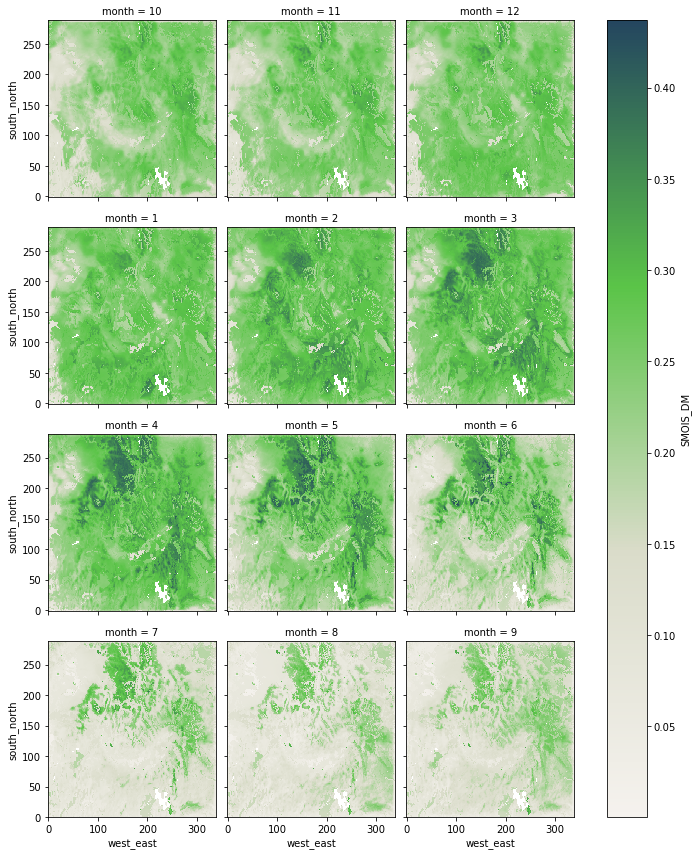

In [7]:
sm_seasonal_surf.plot(x='west_east',y='south_north',col="month",col_wrap=3,cmap=sm_cmap)

In [8]:
sm_seasonal_surf_av = sm_seasonal_surf.mean(dim=('west_east','south_north')).values
sm_seasonal_surf_std = sm_seasonal_surf.std(dim=('west_east','south_north')).values


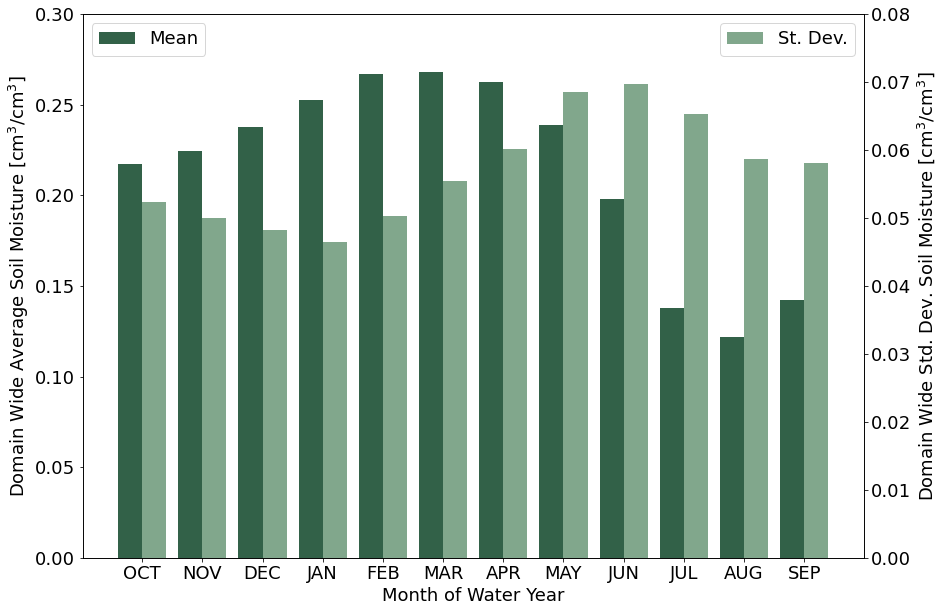

In [9]:
plt.rcParams.update({'font.size': 18})

fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(14)

months = ['OCT','NOV','DEC','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP']

ax.bar(months,sm_seasonal_surf_av, color='#326148', width=-0.4, align='edge',label='Mean')

ax.set_ylim([0.0,0.3])
ax.set_xlabel('Month of Water Year')
ax.set_ylabel('Domain Wide Average Soil Moisture [cm${}^3$/cm${}^3$]')

ax2 = ax.twinx()
ax2.bar(months,sm_seasonal_surf_std, color='#81a78c', width=0.4, align='edge',label='St. Dev.')
ax2.set_ylim([0.0,0.08])
ax2.set_ylabel('Domain Wide Std. Dev. Soil Moisture [cm${}^3$/cm${}^3$]')

ax.legend(loc=2)
ax2.legend(loc=1)

Text(0, 0.5, 'Domain Wide Coefficient of Variation [-]')

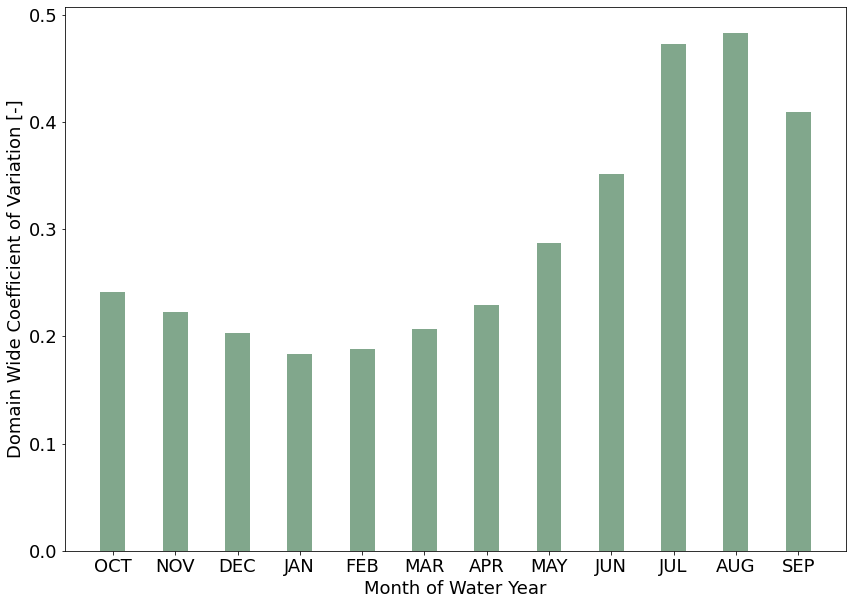

In [10]:
plt.rcParams.update({'font.size': 18})

sm_seasonal_surf_cv = sm_seasonal_surf_std / sm_seasonal_surf_av

fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(14)

months = ['OCT','NOV','DEC','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP']

ax.bar(months,sm_seasonal_surf_cv, color='#81a78c', width=0.4, label='Coeff. Var.')

ax.set_xlabel('Month of Water Year')
ax.set_ylabel('Domain Wide Coefficient of Variation [-]')


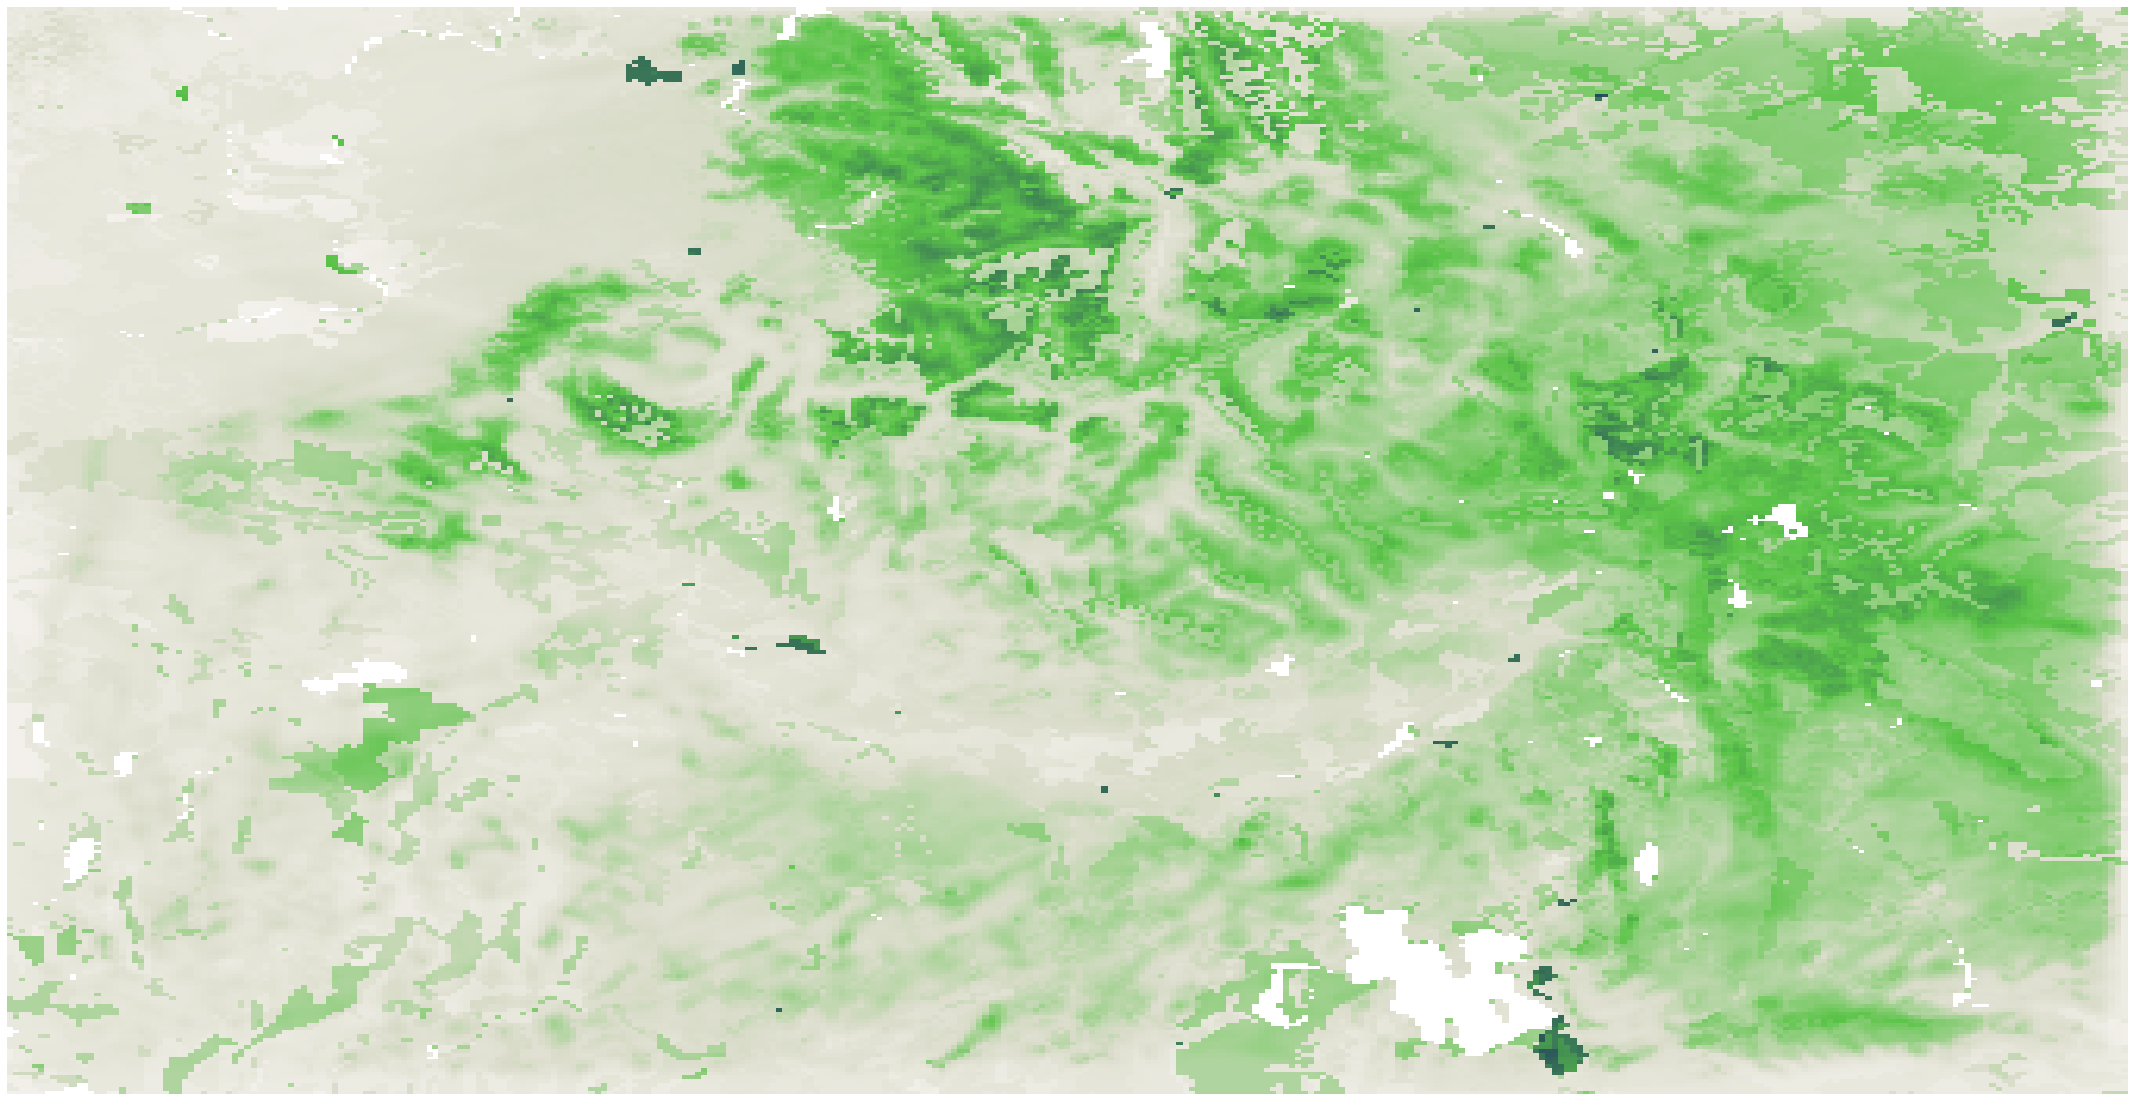

In [25]:
plt.rcParams.update({'font.size': 36})
plt.figure(figsize=(1.9*20,20))

for mon in np.arange(12):
    plt.pcolormesh(sm_seasonal_surf.isel(month=mon), cmap=sm_cmap)
    plt.axis('off')
    pngname = 'surf_sm_'+str(mon)+'.png'
    plt.savefig(pngname, dpi=600, facecolor='w', edgecolor='w', bbox_inches='tight')